## Initialization

### Import packages

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import time
import torch
import random
import numpy as np
import pickle
import torch.nn.functional as F

from copy import deepcopy
from multiprocessing import Pool
from tqdm.notebook import tqdm
from env import Env
from controller_vbc import VDN_MAC
from q_learner_vdn_vbc import QLearner
from run import run
from memory import RecurrentExperienceReplayMemory
from parallel_run_kit import ParallelRun

import matplotlib.pyplot as plt

### Initiliaze environments

In [3]:
test_ues = torch.tensor([[ 2.3219, 35.5963],
        [ 4.9058,  7.3772],
        [34.1434, 24.6237],
        [30.3456, 22.6246],
        [26.9648, 20.9890],
        [19.2420, 32.8353],
        [12.3929, 39.7321],
        [ 5.9339, 29.5289],
        [33.2905, 37.5042],
        [ 9.2728, 15.3940]])

test_env = Env(border=torch.Tensor([40, 40]),
          enbs = torch.Tensor([[10, 10, 10],
                               [10, 30, 10],
                               [10, 10, 30],
                               [10, 30, 30]]),
          ues = test_ues,
          noise = 10**(-11.5),
          rw = 0.02
          )

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [5]:
envs = []


for s in tqdm(range(100)):
    set_seed(s)
#     t_aps = torch.rand(k)
    t_ues = torch.rand(10, 2) * torch.Tensor([40, 40])
    env = Env(border=torch.Tensor([40, 40]),
          enbs = torch.Tensor([[10, 10, 10],
                               [10, 30, 10],
                               [10, 10, 30],
                               [10, 30, 30]]),
          ues = t_ues,
          noise = 10**(-11.5),
          rw = 0.02
          )
    envs.append(env)

  0%|          | 0/100 [00:00<?, ?it/s]

### Initialize models

In [6]:
# set saving directory/name
filename = 'AP4UE10Act5_MARL.pkl'
cuda_flag = True

# initialize learner
controller = VDN_MAC(n_agents = 4) #n_actions = 6 * 5, input_shape = 11
learner = QLearner(controller)
if cuda_flag:
    learner.cuda()

# initialize test learner
test_controller = VDN_MAC(n_agents = 4) #n_actions = 6 * 5, input_shape = 11, n_size = 256
for par in test_controller.env_blender.parameters():
    par.requires_grad = False
for par in test_controller.agent.parameters():
    par.requires_grad = False

### Training

In [11]:
# Defining hyperparams
niterations = 300
max_inner_iter = 64
max_test_iter = 500
epi_length = 500
outerstepsize0 = 1
comm_flag = False
batch_size = 64
memory = RecurrentExperienceReplayMemory(1000)
random_seeds = [0,5,3,6,9,14,16,25,22,29]
k = 0
results_dict = {"loss": None,
               "reward": None}
pbar = tqdm(range(niterations))
best = 0
gamma = 0.98
set_seed(15)
r_history, loss_history = [], []
# Training START!
for k in random_seeds:
    lr = 5e-4
    learner.set_sgd(lr)
    pbar = tqdm(range(niterations))
    env = envs[k]
    r_history, loss_history = [], [] 
#     breakpoint()
    for iteration in pbar: # train 100 episode at a time, so I can change the hyperparameters every 100 episodes
        obs = env.reset()
        inner_step = 0
        if (iteration + 1) % 100 == 0:
            lr = lr/2
            learner.set_sgd(lr)
        losses = []
        controller.init_hidden(1)
        test_mode = False
        batch = {
                    "reward": [], 
                    "actions": [],
                    "obs": [],
                    "state": []
                }
        gamma = 0.98
        r = 0
#         breakpoint()
        for inner_iter in range(max_inner_iter):
            action = controller.choose_action(obs.unsqueeze(0).cuda(), test_mode = test_mode, commu = comm_flag)
            if torch.rand(1) < 0.3 * (1 - iteration/niterations):
                action = torch.randint(6, action.shape).cuda()
            batch["obs"].append(obs)
            batch["actions"].append(action.detach())
            batch["state"].append(env.get_global_obs())
            obs, reward = env.step(action)
            batch["reward"].append(reward)
            r += (1 - gamma) * (reward - r)
            
        
        for key in batch.keys():
#             breakpoint()
            batch[key] = torch.stack(batch[key],axis = 0).unsqueeze(-1).cuda()
            if cuda_flag:
                batch[key].cuda()
        # Transform the training data into a convenient formation.
#         breakpoint()
#         memory.push(batch)
#         if memory.__len__() <= 100:
#             continue
#         breakpoint()
#         batch = memory.sample(batch_size = batch_size)
        
        # train one step. At the same time, check the training loss and the norm of grad.
        if comm_flag:
            loss, grad, diff = learner.train(batch, commu=comm_flag)
        else:
            loss, grad = learner.train(batch, commu=comm_flag)
    # For DQN, it is necessary to update the target network, maybe not important for you
        learner._update_targets()
        # Save the results
        loss_history.append(loss)
    # save and update the test controller
        controller.save('models/' + filename)
        test_controller.load('models/' + filename)
    # The test result also parallel in 8 samples, The following is the Test of the training model
        obs = env.reset()
        test_controller.init_hidden(1)
        for test_iter in range(max_test_iter):
            action = test_controller.choose_action(obs.unsqueeze(0), test_mode = test_mode, commu = comm_flag)
            obs, reward = env.step(action)
            r += (1 - gamma) * (reward - r)
    # save test reward    
        r_history.append(r)
    
        pbar.set_description(f"Env:{k}|Iteration:{episode}|loss:{np.mean(loss_history):.2f}|reward:{r:.2f}")
        if r > best and iteration > 10:
            best = rs
            print(f"Current best {best:.2f} at iteration {iteration}! Saving.... ")
            test_controller.save(f"./models/dqrn_best_marl_env{k}.pkl")
        if (iteration + 1) % 50 == 0:
            plt.plot(r_history)
            plt.show()

            plt.plot(loss_history)
            plt.show()
            results_dict["loss"] = loss_history
            results_dict["reward"] = r_history
            with open(f"./results/env_{k}_marl_results.pkl", "wb") as file:
                pickle.dump(results_dict, file)
        

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

RuntimeError: mat1 dim 1 must match mat2 dim 0

### Draw results

In [16]:
with open("./results/env_0_results.pkl", "rb") as file:
            result = pickle.load(file)

In [18]:
import torch
import numpy as np
import torch.nn as nn
import pickle
import os 
import sys
import matplotlib.pyplot as plt

In [62]:
from glob import glob
dirs = glob("./results/*_results*.pkl")
dirs

['./results/env_5_centralized_results.pkl',
 './results/env_0_centralized_results.pkl',
 './results/env_6_centralized_results.pkl']

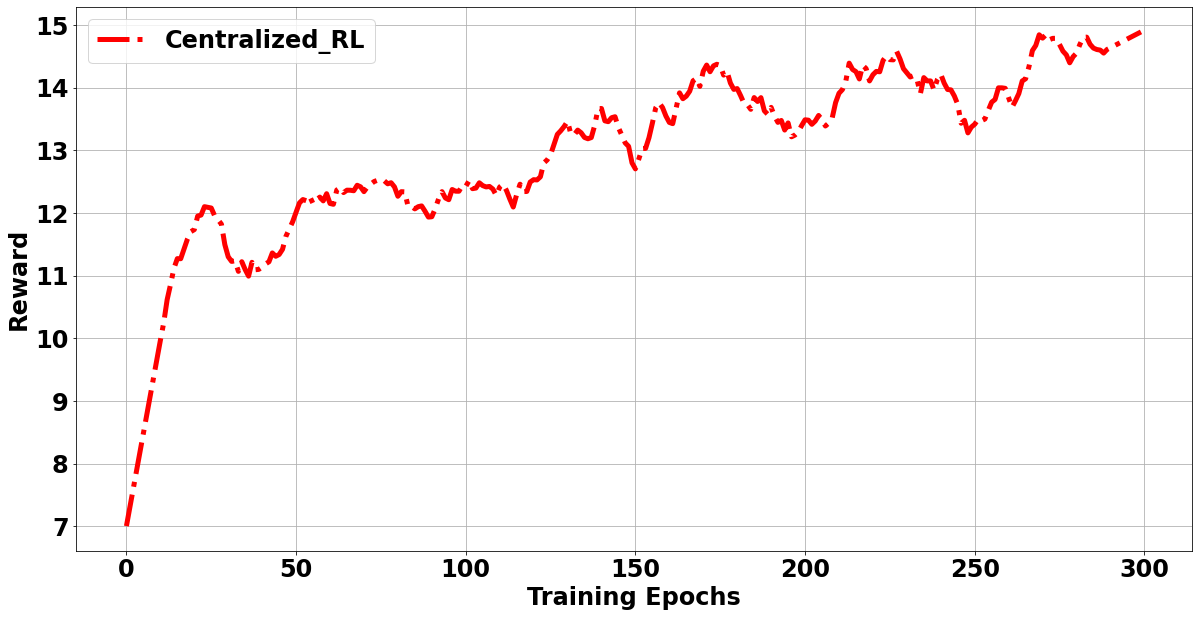

In [63]:
import json
import matplotlib
from scipy.signal import savgol_filter

figure_map= {
    "MARL":["b", "-"],
    "Centralized_RL":["r","-."],
    "Heuristic_baseline":["g",":"]
    
}

font = {'weight' : 'bold',
        'size'   : 24}

results = {}

for i,d in enumerate(dirs):
#     breakpoint()
    d = dirs[i]
    label = dirs[i].split("_")[-2]
    
    
    with open(d, "rb") as f:
#         breakpoint()
        res = pickle.load(f)
        r = res["reward"]
        if label not in results:
            results[label] = np.zeros((len(r),))
            r = np.array(r)
            results[label] += np.array(r)
        else:
            r = np.array(r)
            results[label] += np.array(r)

plt.figure(figsize = (20,10))
if label == "centralized":
    label_n = "Centralized_RL"
plt.plot(savgol_filter(results[label], 21, 1)/len(dirs),c = figure_map[label_n][0],lw=5 ,ls=figure_map[label_n][1], label = label_n)
plt.xlabel("Training Epochs", fontsize=24, weight="bold")
plt.ylabel("Reward", fontsize=24, weight="bold")
matplotlib.rc('font', **font)
plt.grid()
plt.legend()

